<a href="https://colab.research.google.com/github/alexandrehsd/nlp-and-transformers/blob/main/02_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

In this chapter, we are going to work on a task of text classification with transformers. To accomplish that, we are going to use three of the core libraries from the Hugging Face ecosystem: Datasets, Tokenizers, and Transformers.

In [1]:
import importlib
import subprocess

# Libraries to check and install
libraries = ['transformers', 'datasets', 'accelerate>=0.20.1']

for library in libraries:
    try:
        importlib.import_module(library)
        print(f"{library} library is already installed.")
    except ImportError:
        subprocess.check_call(['pip', 'install', library])
        print(f"{library} library installed successfully.")

transformers library is already installed.
datasets library is already installed.
accelerate>=0.20.1 library installed successfully.


## The Dataset

The dataset is comprised of tweets, and the label of the dataset can assume six classes about the sentiment expressed on the tweet:
1. Anger
2. Disgust
3. Fear
4. Joy
5. Sadness
6. Surprise

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 40835 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

It has a dict-like struct with the data splits.

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

we can see what datatypes are being used under the hood:

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


### From Datasets to DataFrames

In [8]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
# convert int labels to str
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

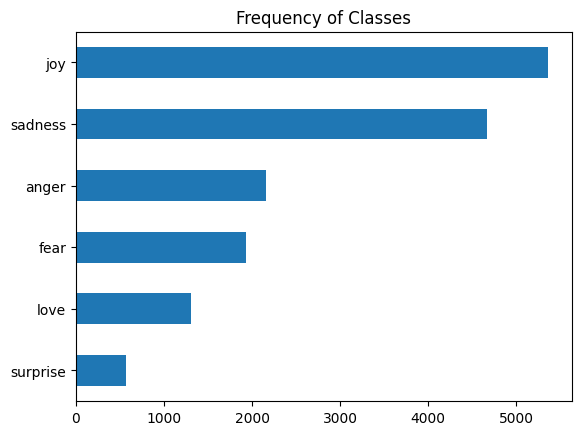

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

We must also consider the average tweet length in tokens per class. The reason for that is because Transformers models have a maximum input sequence length that is referred to as the _maximum context size_.

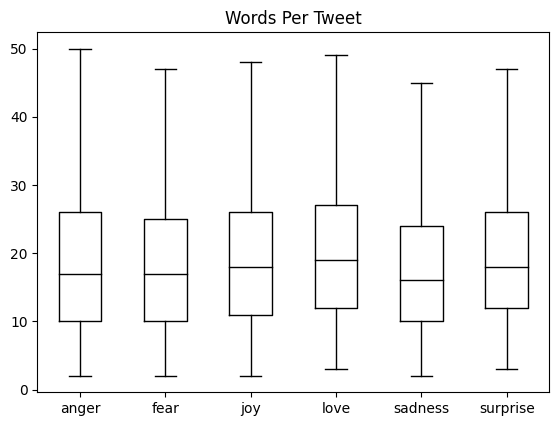

In [11]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

We'll perform the text classification task using DistilBert, a lighter variant of Bert. The maximum context size of that model is 512. Thus, assuming tokens are words, from the previous plot, sequence length won't be a problem for us.

Since we already did some plots, we don't need the dataset in pandas format anymore, let's switch back to the original format.

In [12]:
emotions.reset_format()

### From Text to Tokens

DistilBERT cannot be fed directly with strings, we must tokenize the sentences before inputting them to the model. So, now we are going to spend some time talking about tokenization.

#### Character Tokenization

In [13]:
# doing character tokenization
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Now it's necessary to encode each string as an integer:

In [14]:
token2idx =  {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
token2idx

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

With that mapping dictionary, we can transform a sentence into a sequence of integers:

In [15]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


The last step is to convert `input_ids` to a 2D tensor of one-hot vectors.

In [16]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

one_hot_encodings.shape

torch.Size([38, 20])

In [17]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [18]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [19]:
token2idx =  {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
token2idx

{'NLP.': 0,
 'Tokenizing': 1,
 'a': 2,
 'core': 3,
 'is': 4,
 'of': 5,
 'task': 6,
 'text': 7}

In [20]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[1, 7, 4, 2, 3, 6, 5, 0]


In [21]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))

one_hot_encodings.shape

torch.Size([8, 8])

In [22]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: Tokenizing
Tensor index: 1
One-hot: tensor([0, 1, 0, 0, 0, 0, 0, 0])


The problem with word tokenization is that there may be many variants of a single word. Besides, depending on the tokenization method, we can get some erroneos tokens such as 'NLP.' in the example above.

We can use stemming or lemmatization to standardize tokens, but we lose information in the process. Consider a corpus of words containing 1M words. If we wish to use a neural network to reduce these representations to a 1,000 dimensional vector we would need 1M x 1K = 1B weights. That's too much to process.

An alternative approach would be to get the top 100,000 words and put the rest under a UNK token. In that way, we would still be losing information but it would be less harmful to the training process.

Using subword tokenization, we get a compromise between character and word tokenization where we can preserve all the input information and some of the input structure.

#### Subword Tokenization

To perform subword tokenization, we'll be using WordPiece, which is used by the BERT and DistilBERT tokenizers.

In [23]:
# load the DistilBERT tokenizer with AutoTokenizer
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [24]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [25]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In this specific tokenizer, the '[CLS]' and '[SEP]' tokens indicate the begginning and the end of the sentence. Additionally, tokens starting with '##' area rare tokens and the occurence of '##' indicate the they should be merged back to the original string when tokens are converted back to string.

In [26]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [27]:
tokenizer.vocab_size

30522

In [28]:
tokenizer.model_max_length

512

#### Tokenizing the Whole Dataset

In [29]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [30]:
 tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [31]:
# use the map method to tokenize the whole dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

Models like DistilBERT are pretrained to predict masked words in a sequence of text. Thus, to perform text classification, we must change a few things on its architecture.

We have two options to train such a model on our Twitter dataset:

1. Feature Extraction: We use the hidden states as features and just train a classifier on them, without modifying the pretained model.
2. Fine-Tuning: We train thw whole model end-to-end, which also updates the parameters of the pretrained model.

### Transformers as Features Extractors

In [32]:
# Load the DistilBERT to load the weights of the pretrained DistilBERT model
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The AutoModel calss converts the token encodings to embeedings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at houw we can extract these states from our corpus.

#### Extracting the last hidden states

In [33]:
# getting the last hidden states for a single string
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [34]:
# pass the input through the model
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [35]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

The hidden state tensor has shape [batch_size, n_tokens, hidden_dim]. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [36]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [37]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return the vector for [CLS] token
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [38]:
# the model expects tensors as inputs
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [39]:
# extract hidden states accros all splits in one go
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

#### Creating a feature matrix

We need to create a feature matrix to train a classifier.

In [40]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

In [41]:
# import umap
# from sklearn.preprocessing import MinMaxScaler # Scale features to [0,1] range

# X_scaled = MinMaxScaler().fit_transform(X_train)

# # Initialize and fit UMAP
# mapper = umap.umap_(n_components=2, metric="cosine").fit(X_scaled)

# # Create a DataFrame of 2D embeddings
# df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
# df_emb["label"] = y_train
# df_emb.head()

In [42]:
# fig, axes = plt.subplots(2, 3, figsize=(7,5))
# axes = axes.flatten()
# cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

# for i, (label, cmap) in enumerate(zip(labels, cmaps)):
#   df_emb_sub = df_emb.query(f"label == {i}")
#   axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
#   axes[i].set_title(label)
#   axes[i].set_xticks([]), axes[i].set_yticks([])

# plt.tight_layout()
# plt.show()

#### Training a simple classifier

In [43]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

In [44]:
from sklearn.dummy import DummyClassifier

# Training a baseline classifier that predicts the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

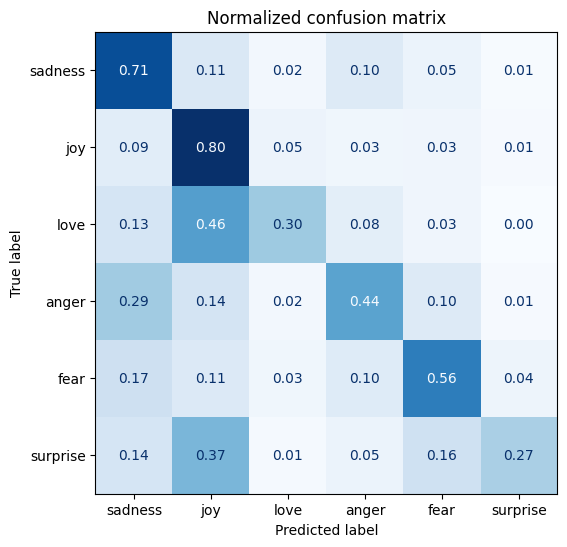

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

In this section, we'll train a classifier using the Trainer API from transformers.

In [46]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.we

##### Defining the performance metrics

In [47]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

In [48]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [50]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"], eval_dataset=["validation"],
                  tokenizer=tokenizer)

In [51]:
trainer.train()

Epoch,Training Loss,Validation Loss


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2035 in _inner_training_loop     │
│                                                                                                  │
│   2032 │   │   │   │   self.control.should_training_stop = True                                  │
│   2033 │   │   │                                                                                 │
│   2034 │   │   │   self.control = self.callback_handler.on_epoch_end(args, self.state, self.con  │
│ ❱ 2035 │   │   │   self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_  │
│   2036 │   │   │                                                                                 │
│   2037 │   │   │   if DebugOption.TPU_METRICS_DEBUG in self.args.debug:                          │
│   2038 │   │   │   │   if is_torch_tpu_available():                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2321 in _maybe_log_save_evaluate │
│                                                                                                  │
│   2318 │   │   │   │   │   )                                                                     │
│   2319 │   │   │   │   │   metrics.update(dataset_metrics)                                       │
│   2320 │   │   │   else:                                                                         │
│ ❱ 2321 │   │   │   │   metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)                 │
│   2322 │   │   │   self._report_to_hp_search(trial, self.state.global_step, metrics)             │
│   2323 │   │   │                                                                                 │
│   2324 │   │   │   # Run delayed LR scheduler now that metrics are populated                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3053 in evaluate                 │
│                                                                                                  │
│   3050 │   │   start_time = time.time()                                                          │
│   3051 │   │                                                                                     │
│   3052 │   │   eval_loop = self.prediction_loop if self.args.use_legacy_prediction_loop else se  │
│ ❱ 3053 │   │   output = eval_loop(                                                               │
│   3054 │   │   │   eval_dataloader,                        

In [54]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(columns=tokenizer_columns,
                                                           label_cols=["label"],
                                                           shuffle=True,
                                                           batch_size=batch_size)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(columns=tokenizer_columns,
                                                               label_cols=["label"],
                                                               shuffle=False,
                                                               batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [57]:
preds_output = trainer.predict(emotions_encoded["validation"] )

Epoch,Training Loss,Validation Loss


In [58]:
preds_output.metrics

{'test_loss': 0.1777583509683609,
 'test_accuracy': 0.928,
 'test_f1': 0.9277373949988715,
 'test_runtime': 4.3381,
 'test_samples_per_second': 461.036,
 'test_steps_per_second': 7.377}

In [59]:
y_preds = np.argmax(preds_output.predictions, axis=1)

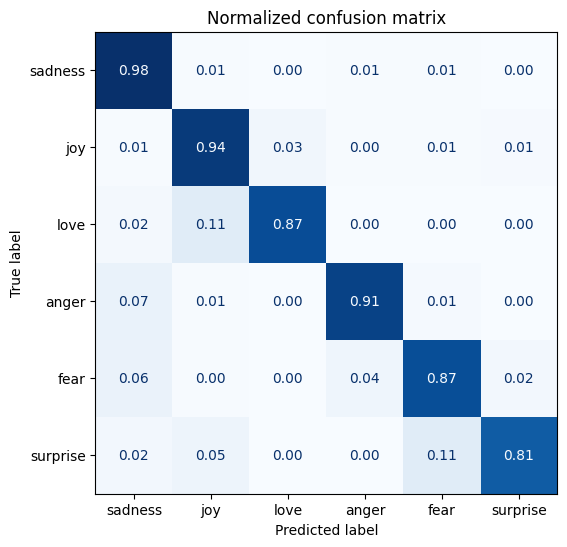

In [60]:
plot_confusion_matrix(y_preds, y_valid, labels)